In [17]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [12]:
d = 2

ps_list = [
    np.array([0.1, 0.9]),
    np.array([0.2, 0.8]),
    np.array([0.4, 0.6]),
]

N_list = [100, 100, 100]
N = np.sum(N_list)

mu = np.array([0.2, 0.3])

def gen_data(ps_list, N_list, mu):
    N = np.sum(N_list)
    
    obs = np.zeros(N)
    design = np.zeros((N, d))
    
    chosen_as = np.zeros(N)
    
    compt = 0
    for i, Ni in enumerate(N_list):
        p = ps_list[i]
        for j in range(Ni):
            design[compt + j, :] = p
            a = np.random.choice(d, p=p)
            obs[compt + j] = 1*(np.random.rand() < mu[a])
            chosen_as[compt+j] = a
        compt += Ni
    return design, obs, chosen_as

design, obs, chosen_as =  gen_data(ps_list, N_list, mu)

#print(design)

In [14]:
lam = 0.01
delta = 0.1

V = lam*np.eye(d) + np.matmul( design.T, design)
np.matmul(design.transpose(), obs)
mu_hat_reg =  np.matmul(np.linalg.inv(V), np.matmul(design.T, obs))
mu_hat_coord = np.array([ np.sum((chosen_as == a) * obs )/ np.sum((chosen_as == a))   for a in range(d)])

print(mu_hat_reg, mu_hat_coord)

Na = np.array([np.sum((chosen_as == a)) for a in range(d)])

print(Na)

def check_in_ct_rectangle(theta):
    return np.all( Na * np.square( theta - mu_hat_coord) <= (1/4) * np.log(N / delta) )

def kl(p, q):
    assert((0<=p<=1)and(0<=q<=1))
    if q==0 or q==1:
        return 10000.
    elif p==0 or p==1:
        return p*np.log(1/ q) + (1-p)*np.log(1 / (1-q))
    else:
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))


def check_in_ct_kl(theta, rect=True):
    if rect : 
        return np.all( [Na[a] * kl(mu_hat_coord[a], theta[a]) <= np.log(1/delta) for a in range(d)])
    else:
        return np.sum( [Na[a] * kl(mu_hat_coord[a], theta[a])  for a in range(d)] ) <= d * np.log(1/delta) 

def check_in_ct_ellipse(theta):
    return np.sqrt(np.dot(theta - mu_hat_reg, np.matmul(V, theta - mu_hat_reg))) <= (1/4)* np.sqrt(d * np.log( (1 + (N/lam)) / delta) ) + np.sqrt(lam)


print(check_in_ct_rectangle(mu))
print(check_in_ct_kl(mu))
print(check_in_ct_ellipse(mu))

[0.36533998 0.28008586] [0.21538462 0.32340426]
[ 65 235]
True
True
True


<IPython.core.display.Javascript object>


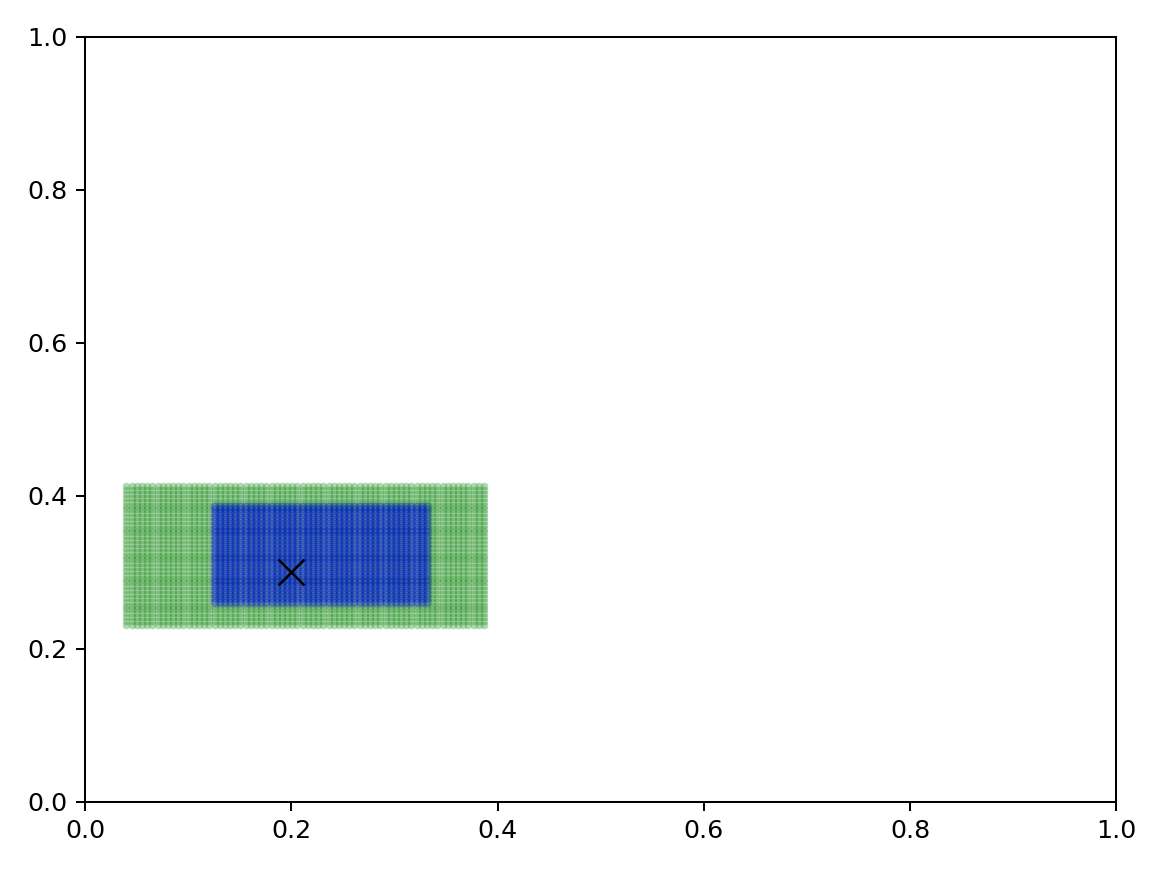

In [19]:
nx, ny = 200, 200
xs, ys = np.linspace(0, 1, nx), np.linspace(0, 1, ny)

in_ct_ell = np.zeros((nx, ny))
in_ct_rect = np.zeros((nx, ny))

for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        #in_ct_ell[i, j] = check_in_ct_ellipse([x, y])
        #if check_in_ct_ellipse([x, y]):
        #    plt.plot(x, y, 'ro', alpha=0.2, ms=3, markeredgewidth=0.0, fillstyle="full")
        #in_ct_rect[i, j] = check_in_ct_rectangle([x, y])
        if check_in_ct_rectangle([x, y]):
            plt.plot(x, y, 'go', alpha=0.3, ms=3, markeredgewidth=0.0)
        if check_in_ct_kl([x, y], rect=True):
            plt.plot(x, y, 'bo', alpha=0.2, ms=3)
        
plt.plot(mu[0], mu[1], 'x', color='black', ms=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
plt.tight_layout()

In [243]:
plt.close()

In [84]:
a = np.array([[1, 2], [3, 4]])
print(a)

[[1 2]
 [3 4]]


In [85]:
a.transpose()

array([[1, 3],
       [2, 4]])

In [86]:
print(a)

[[1 2]
 [3 4]]


<IPython.core.display.Javascript object>


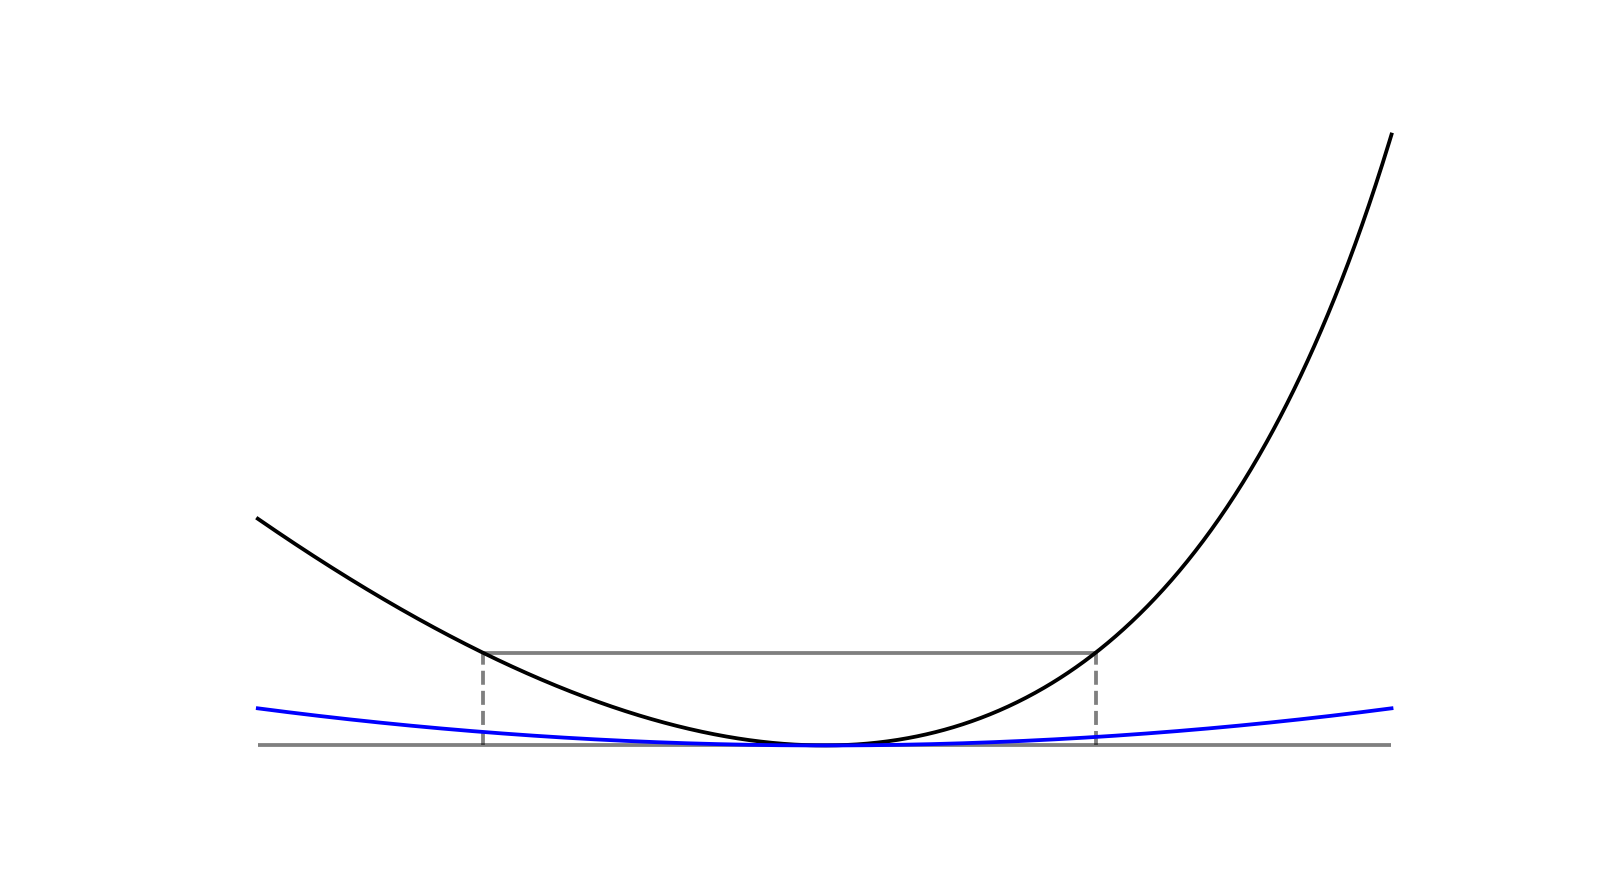

In [294]:
x0 = 1 -0.03
eps= 0.02
xs = np.linspace(x0 - eps, x0 +eps, 1000)

alpha = 0.002

def u_kl_right(mu, alpha, precision=1e-7):
    assert((0<=mu<=1))
    if mu>1-precision:
        return 1
    r = 1.
    delta = 1 - mu
    while True:
        delta = delta / 2
        if kl(mu, r) > alpha + precision:
            r = r - delta
        elif kl(mu, r) < alpha - precision:
            r = r + delta
        else:
            return r

def u_kl_left(mu, alpha, precision=1e-7):
    assert((0<=mu<=1))
    if mu < precision:
        return 0
    r = 0.
    delta =  mu
    while True:
        delta = delta / 2
        if kl(mu, r) > alpha + precision:
            r = r + delta
        elif kl(mu, r) < alpha - precision:
            r = r - delta
        else:
            return r

l_kl = u_kl_left(x0, alpha)
u_kl = u_kl_right(x0, alpha)
        
plt.hlines(alpha, xmin=l_kl, xmax=u_kl, alpha=0.5)
plt.hlines(0, xmin=x0 - eps, xmax=x0 + eps, alpha=0.5)

plt.vlines([l_kl, u_kl], ymin=0, ymax=alpha, alpha=0.5, linestyle='--')


plt.plot(xs, [ kl(x0, x) for x in xs], color="black")
plt.plot(xs, [2*(x0 - x)**2  for x in xs], color="blue")

plt.axis('off')

plt.show()

In [287]:
plt.savefig('kl_ucbs.pdf')